In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import pandas_profiling as pp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta

In [2]:
pac17 = pd.read_csv('PAC_2017_12.csv', sep = ';', error_bad_lines = False, encoding = 'latin-1')
conversao_digs = pd.read_csv('conversao_digs.csv', sep = ';', error_bad_lines = False, encoding = 'utf8')
pac17 = pac17.drop(columns = ['aaa'])
pac17.shape

/home/fguer/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3,10,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(33831, 16)

# Descrição dos dados

# Pré-processamento dos Dados

A coluna *investimento_total* no dataset ```pac17``` contém incosistências de formatação com valores em vírgula e ponto. A célula abaixo troca ```,``` por ```.``` e converte o formato da coluna para numérico.

In [3]:
pac17['investimento_total'] = pac17.investimento_total.replace(',','.', regex=True).astype('float64')

In [4]:
def change_type_by_name(data, string, final_type):
    for col in data.columns:
        if string in col:
            data[col] = data[col].astype(final_type)
    return data
pac17 = change_type_by_name(pac17, 'idn_', 'object')

Considerando apenas os dados quem contém o código __BA__ na sigla do estado do empreendimento e desconsiderando os dados onde `sigla_uf` apresenta valores __NULL__.

In [5]:
pac17 = pac17.dropna(subset = ['sig_uf'])
pacba17 = pac17[pac17['sig_uf'].str.contains('BA')]

In [6]:
pacba17['idn_digs'] = pacba17.idn_digs.astype('str')
pacba17['idn_digs'] = pacba17['idn_digs'].map(lambda x: str(x)[:-2])
conversao_digs['idn_digs'] = conversao_digs.idn_digs.astype('str')

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
pacba17 = pacba17.join(conversao_digs.set_index('idn_digs'), on='idn_digs')

In [8]:
pacba17.dtypes

idn_empreendimento        object 
idn_digs                  object 
dsc_titulo                object 
investimento_total        float64
sig_uf                    object 
txt_municipios            object 
txt_executores            object 
dsc_orgao                 object 
idn_estagio               object 
dat_ciclo                 object 
dat_selecao               object 
dat_conclusao_revisada    object 
obra_latitude             object 
obra_longitude            object 
emblematica               object 
observacao                object 
tipo_empreendimento       object 
subeixo                   object 
dtype: object

### Feature Engineering

In [9]:
pacba17['idn_estagio'] = pacba17.idn_estagio.astype('int')

In [10]:
pacba17['estagio'] = np.where(pacba17['idn_estagio'] >= 70, 'em_obras', 'nao_iniciado')
pacba17['estagio'] = np.where(pacba17['idn_estagio'] == 90, 'concluido', pacba17['estagio'])

In [11]:
pacba17.dtypes

idn_empreendimento        object 
idn_digs                  object 
dsc_titulo                object 
investimento_total        float64
sig_uf                    object 
txt_municipios            object 
txt_executores            object 
dsc_orgao                 object 
idn_estagio               int64  
dat_ciclo                 object 
dat_selecao               object 
dat_conclusao_revisada    object 
obra_latitude             object 
obra_longitude            object 
emblematica               object 
observacao                object 
tipo_empreendimento       object 
subeixo                   object 
estagio                   object 
dtype: object

### Explorando a coluna `dat_selecao`

1. Preencher os 92 valores vazios no caso de obras concluídas a partir da mediana do número de obras.
2. Preecher os 121 valores vazios no caso de obras em andamento com a moda das datas de seleção (dia, mês, ano).
3. 192 valores vazios no caso de obras ainda não iniciadas.

In [12]:
def values_from_dates(df, column, day, month, year):
    df[day] = df[column].str.slice(0,2)
    df[month] = df[column].str.slice(3,5)
    df[year] = df[column].str.slice(6,10)
    return df
def conclusion_status(df, col):
    df[col] = np.where(df.dat_conclusao_revisada.notna(), 'sim', 'nao')
    return df

- Considera uma parte do dataset em que o estágio das obras é concluído e não há valores nulos na data de seleção.
- Confere que não há valores vazios em `dat_selecao` e `dat_conclusao_revisada`.
- Converte essas colunas para _datetime_.
- Calcula o número de dias das obras e guarda a sua __mediana__.

In [13]:
concluido = pacba17[(pacba17['estagio'] == 'concluido') & (pacba17.dat_selecao.notnull())]

In [14]:
assert concluido.dat_selecao.isnull().sum() == 0 and concluido.dat_conclusao_revisada.isnull().sum() == 0

In [15]:
concluido['dat_selecao'] = pd.to_datetime(concluido['dat_selecao'], dayfirst=True)
concluido['dat_conclusao_revisada'] = pd.to_datetime(concluido['dat_conclusao_revisada'], dayfirst=True)

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
concluido['dias_obra'] = (concluido['dat_conclusao_revisada'] - concluido['dat_selecao']).dt.days

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
concluido_median = int(concluido['dias_obra'].median())

In [18]:
del(concluido)

Substitui os valores vazios da `dat_seleção` pela __moda__ onde o `estagio` é diferente de concluído.

In [19]:
nao_concluido_moda = pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.notnull())].mode()

In [20]:
pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.isnull())] = str(nao_concluido_moda[0])

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
pacba17['dat_conclusao_revisada'] = pacba17['dat_conclusao_revisada'].fillna(pacba17['dat_selecao'])

In [22]:
assert pacba17.dat_conclusao_revisada.isnull().sum() == 0

In [23]:
pacba17['dat_selecao'] = pd.to_datetime(pacba17['dat_selecao'], dayfirst=True)
pacba17['dat_conclusao_revisada'] = pd.to_datetime(pacba17['dat_conclusao_revisada'], dayfirst=True)

In [24]:
pacba17['dat_selecao'] = pacba17['dat_selecao'].fillna(pacba17['dat_conclusao_revisada'] - timedelta(days=concluido_median))

In [25]:
assert pacba17.dat_selecao.isnull().sum() == 0

In [26]:
pacba17['dias_obra'] = (pacba17['dat_conclusao_revisada'] - pacba17['dat_selecao']).dt.days

In [27]:
pacba17['dia_conclusao'] = pacba17.dat_conclusao_revisada.dt.day
pacba17['mes_conclusao'] = pacba17.dat_conclusao_revisada.dt.month
pacba17['ano_conclusao'] = pacba17.dat_conclusao_revisada.dt.year
pacba17['dia_selecao'] = pacba17.dat_selecao.dt.day
pacba17['mes_selecao'] = pacba17.dat_selecao.dt.month
pacba17['ano_selecao'] = pacba17.dat_selecao.dt.year

### Missing values

#### Exclusão das colunas com missing values acima de 50%

Dropa as colunas ``emblematica`` e ``observação`` dado o alto percentual de _missing values_

In [28]:
pacba17 = pacba17.drop(columns = ['emblematica', 'observacao'])

#### Plota as colunas com missing values

In [29]:
def plot_missing(df):
    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    unique = df.nunique()
    dtypes = df.dtypes
    missing_value_data = pd.DataFrame({'column_name': columns,
                                     'percent_missing': percent_missing,
                                     'unique': unique,
                                     'types': dtypes})
    missing_value_data = missing_value_data[missing_value_data['percent_missing']>0]
    missing_value_data=missing_value_data.sort_values(by=['percent_missing'], ascending=False)
    
    plt.figure(figsize=(9, 6))
    ax = sns.barplot(x="column_name", y="percent_missing", hue='types', data=missing_value_data)
    ax.axhline(50, ls='--', color = 'r')
    ax.text(3,51,"50% of missing values", color = 'r')
    ax.set_title("Percentage of Missing Values by column")
    plt.xticks(rotation=45)
    print percent_missing
    plt.show()

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


idn_empreendimento        0.000000 
idn_digs                  0.000000 
dsc_titulo                0.000000 
investimento_total        12.956153
sig_uf                    0.000000 
txt_municipios            1.272984 
txt_executores            0.424328 
dsc_orgao                 1.640736 
idn_estagio               0.000000 
dat_ciclo                 0.000000 
dat_selecao               0.000000 
dat_conclusao_revisada    0.000000 
obra_latitude             5.346535 
obra_longitude            5.346535 
tipo_empreendimento       0.000000 
subeixo                   0.000000 
estagio                   0.000000 
dias_obra                 0.000000 
dia_conclusao             0.000000 
mes_conclusao             0.000000 
ano_conclusao             0.000000 
dia_selecao               0.000000 
mes_selecao               0.000000 
ano_selecao               0.000000 
dtype: float64


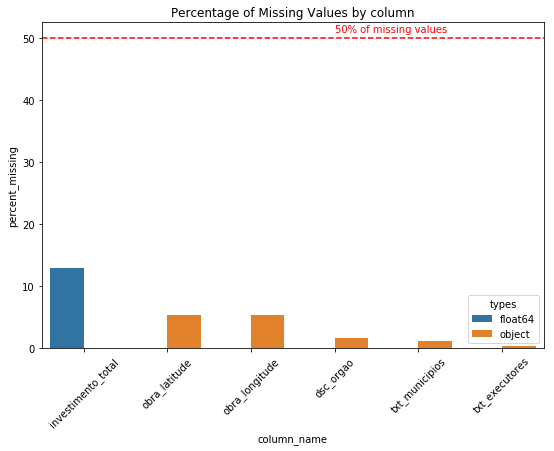

In [30]:
plot_missing(pacba17)

In [31]:
pacba17 = pacba17.dropna(subset=['obra_latitude', 'obra_longitude', 'dsc_orgao','txt_municipios', 'txt_executores'])

### Divisão do dataset para desenvolvimento e produção

Separação do dataset original para o dataset que será usado para treinar e testar o modelo e outro que será usado para o modelor estimar os valores de investimento.
- Critério de split:
    - Dataset de desenvolvimento: `investimento_total` diferentes de nulo;
    - Dataset para produção: `investimento_total` com valores nulo;

In [32]:
shape_dev = pacba17.shape[0]

In [33]:
pacba17 = pacba17.dropna(subset=['investimento_total'])

In [34]:
shape_prod = pacba17.shape[0]

In [35]:
dev = float(shape_prod)/(shape_dev)
prod = float(shape_dev - shape_prod)/(shape_dev)

In [36]:
print('{0:.0%} do dataset será usado para desenvolvimento e {1:.0%} como dados de previsão após finalização do modelo'.format(dev, prod))

90% do dataset será usado para desenvolvimento e 10% como dados de previsão após finalização do modelo


### Tratando outliers

#### `investimento_total`

Detectando Outliers a partir do __Z-score__

In [37]:
z = np.abs(stats.zscore(pacba17['investimento_total']))

In [38]:
print(np.where(z >3))

(array([   2,    5,    6,    7,   10,   14,   16,   17,   18,  344,  345,
        383,  384,  399,  400,  550,  553,  557,  560,  562,  742, 1132,
       1133, 1173, 1177, 1178, 1184, 1199, 2738, 2739, 2740, 2741, 2748,
       2749, 2754, 2755, 2756, 2757, 2762, 2763, 2766, 2767, 2770, 2772,
       2773, 2774, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2945,
       2947, 2948, 2949, 2950, 2951, 2952, 2953, 2956, 2959]),)


In [39]:
pacba17 = pacba17[z<3]

In [40]:
pacba17['log_investimento_total'] = np.log(pacba17['investimento_total'])

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


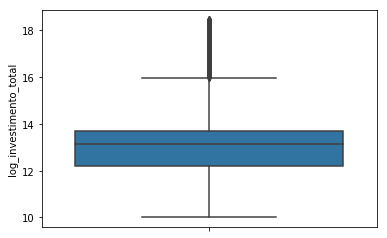

In [41]:
sns.boxplot(y=pacba17['log_investimento_total'])

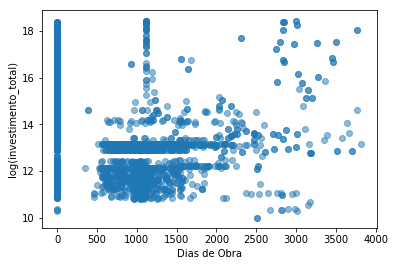

In [42]:
plt.scatter(pacba17['dias_obra'], pacba17['log_investimento_total'], alpha=0.5)
plt.xlabel('Dias de Obra')
plt.ylabel('log(investimento_total)')
plt.show()

/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/fguer/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'log(investimento_total)')

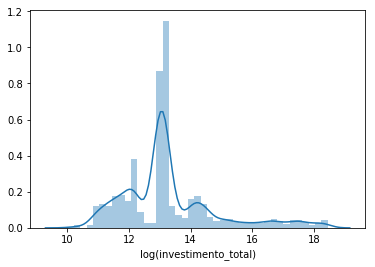

In [43]:
sns.distplot(pacba17['log_investimento_total'])
plt.xlabel('log(investimento_total)')

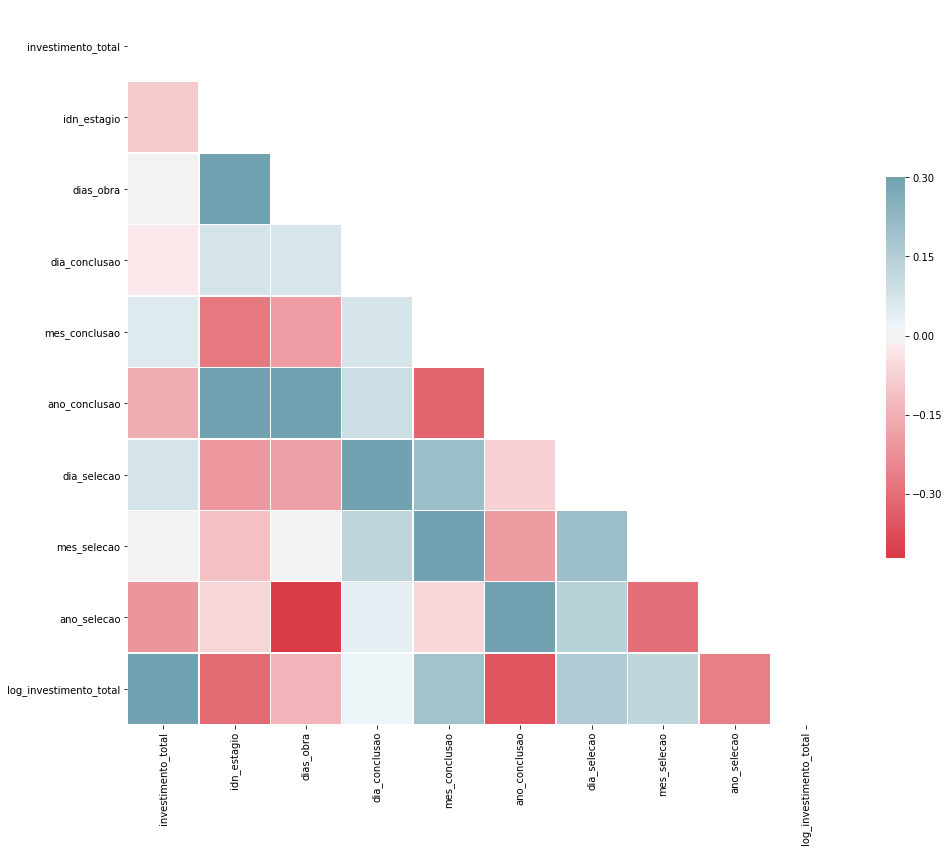

In [44]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Count de UFs__
- Criar coluna calculada com o número de estados.
- Dummificar essa coluna (?).

In [45]:
pacba17 = pacba17.drop(columns=['idn_estagio', 'dat_ciclo', 'dat_selecao', 'dat_conclusao_revisada'])

__Converte as colunas Latitude e Longitude de DMS para decimal__

Precisa ser completado: Splitar os campos com valores multiplos e aplicar a função de conversão

Dropa Colunas que serão utilizadas (ou não) porsteriormente:
- `sig_uf`: criar coluna calculada com número de estados.
- `txt_municipios`: criar coluna calculada com número de municípios.
- `obra_latitude`, `obra_longitude`: converter pra decimal.

In [46]:
pacba17 = pacba17.drop(columns = ['idn_empreendimento', 'dsc_titulo', 'sig_uf', 'txt_municipios', 'obra_latitude','obra_longitude'])

### Getting dummies

In [47]:
pacba17_dummies = pd.get_dummies(pacba17,columns=['dsc_orgao', 'tipo_empreendimento', 'subeixo', 'estagio'], dummy_na=False)

In [48]:
pacba17_dummies = pacba17_dummies.drop(columns=['idn_digs'])

#### WARNING!!!!!!
`txt_executores` com 82 valores únicos está sendo encoded!!

In [49]:
pacba17_dummies = pacba17_dummies.drop(columns=['txt_executores', 'investimento_total'])

Através da matriz de correlação, avaliando a relação entre a variável target `investimento_total` e as outras, percebe-se:
- Alta correlação negativa: Obras pertencentes ao subeixo de Infraestrutura Social apresentam menores 

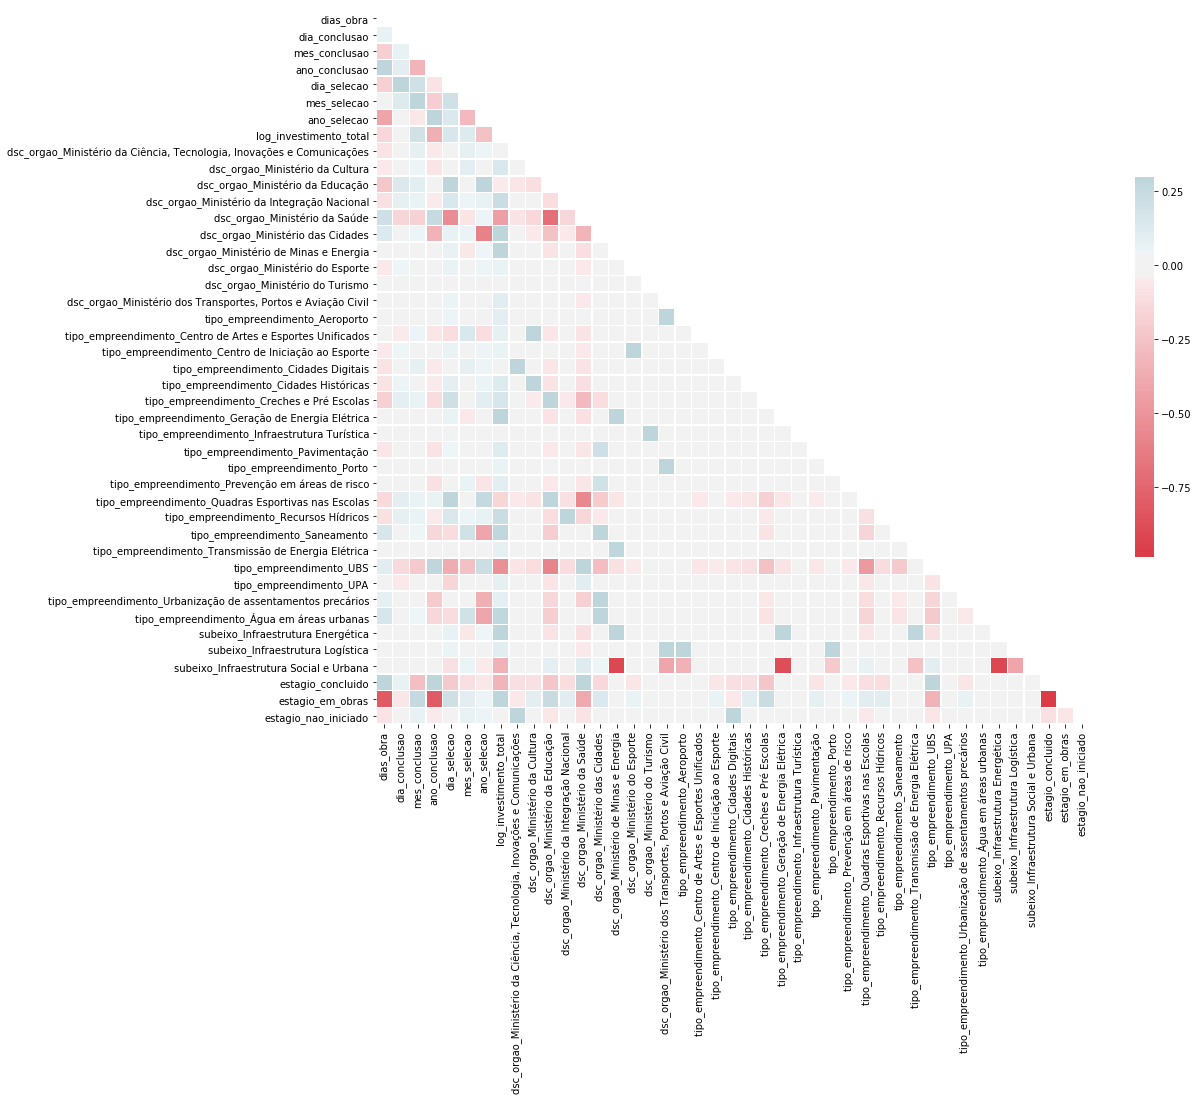

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17_dummies.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Shuffle and Split Data

In [51]:
features = pacba17_dummies.drop(columns='log_investimento_total')
prices = pacba17_dummies['log_investimento_total']

In [52]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.3, random_state=10)

print "Training and testing split was successful."

Training and testing split was successful.


/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Evaluation Metrics

1. Mean Absolute Error (MAE).
2. Mean Square Error (MSE).
3. Root Mean Square Error (RMSE).

In [77]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [54]:
def evaluate(X, Y,model):
    scores = ['neg_mean_absolute_error','neg_mean_squared_error','r2']
    results = 0
    for score in scores:
        results = cross_val_score(model, X, Y, cv=kfold, scoring=score)
        print('{}| mean {}| std {}'.format(score,results.mean(),results.std()))

In [55]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [56]:
LN = LinearRegression()
evaluate(features, prices, LN)

neg_mean_absolute_error| mean -0.640514960582| std 0.0255517312611
neg_mean_squared_error| mean -0.781020419285| std 0.0936721041492
r2| mean 0.676534511438| std 0.0493388748658


#### Benchmark Model

In [57]:
LN.fit(X_train, y_train)
y_pred = LN.predict(X_test)

In [58]:
def evaluate_model(model, y, y_pred):
    assert len(y) == len(y_pred)
    print('-'*40)
    print(model)
    print('Mean Square Error:{}'.format(mean_squared_error(y, y_pred)))
    print('Mean Absolute Error:{}'.format(mean_absolute_error(y, y_pred)))
    print('Root Mean Square Error:{}'.format(np.sqrt(mean_squared_error(y, y_pred))))

----------------------------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean Square Error:0.804560607556
Mean Absolute Error:0.664216524074
Root Mean Square Error:0.896973024988


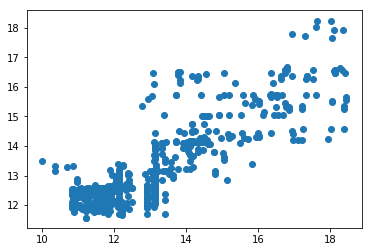

In [59]:
evaluate_model(LN,y_test, y_pred)
plt.scatter(y_test, y_pred)

## Model Selection

In [60]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [86]:
models = {"RandomForest_Regressor" : RandomForestRegressor(n_estimators = 15, min_samples_split=2, random_state = 42, min_samples_leaf=1),
"KNeighbors_Regressor" : KNeighborsRegressor(n_neighbors= 3),
"ExtraTrees_Regressor" : ExtraTreesRegressor(n_estimators=8, criterion='mse'),
"SVRegressor" : SVR(kernel='rbf', gamma='auto'),
"AdaBoost_Regressor" : AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators = 15,random_state = 42)),
"Bagging_Regressor" : BaggingRegressor(),
"GradientBoosting_Regressor" : GradientBoostingRegressor()}

In [87]:
for name, model in models.items():
    start = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    finish = datetime.now()
    evaluate_model(name, y_test, y_pred)
    print("Runnig time: {}s".format((finish - start).total_seconds()))

----------------------------------------
RandomForest_Regressor
Mean Square Error:0.571596272254
Mean Absolute Error:0.497358835283
Root Mean Square Error:0.756039861551
Runnig time: 0.127125s
----------------------------------------
SVRegressor
Mean Square Error:1.07269408551
Mean Absolute Error:0.623645773089
Root Mean Square Error:1.03570945999
Runnig time: 0.465662s
----------------------------------------
ExtraTrees_Regressor
Mean Square Error:0.617709191121
Mean Absolute Error:0.491924676077
Root Mean Square Error:0.785944776127
Runnig time: 0.048086s
----------------------------------------
KNeighbors_Regressor
Mean Square Error:0.889715525383
Mean Absolute Error:0.612171340521
Root Mean Square Error:0.94324732991
Runnig time: 0.027742s
----------------------------------------
GradientBoosting_Regressor
Mean Square Error:0.627691263612
Mean Absolute Error:0.553494858892
Root Mean Square Error:0.792269691211
Runnig time: 0.296974s
----------------------------------------
Bagging_

### Tunning Model Parameters

#### Bagging Regressor

#### Random Forest Regressor